Here is some code to read in model-simulated PM2.5 data (in a netCDF file) and compare it to WHO measurements.

Code written by Dr Ben Silver and Dr Carly Reddington.

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np

data_path = './example_data/'

Open measurement data from the WHO Database and extract PM2.5 concentrations (annual mean):

In [10]:
obs

,city,year,pm25_concentration,latitude,longitude
0,Chennai,2018,30.0,13.087840,80.278470
1,Solapur,2016,39.0,17.659919,75.906391
2,Chennai,2019,39.0,13.087840,80.278470
3,Hyderabad,2019,42.0,17.384050,78.456360
4,Pune,2017,43.0,18.505320,73.823839
...,...,...,...,...,...
41359,Jizan,2014,NaN,16.885875,42.573386
41360,Jizan,2013,NaN,16.885875,42.573386
41361,Jizan,2012,NaN,16.885875,42.573386
41362,Jizan,2011,NaN,16.885875,42.573386


In [81]:
ff.pm25_concentration.sum()

5077.0

<BarContainer object of 1156 artists>

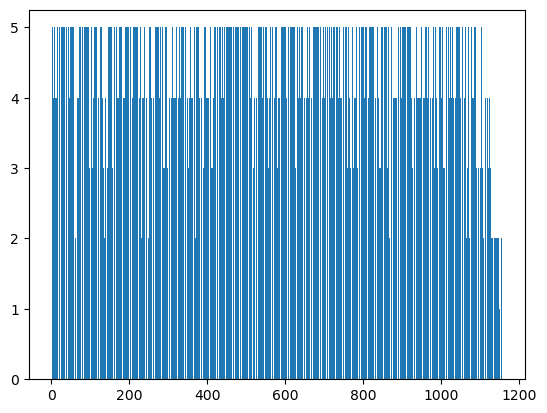

In [95]:
gg=np.arange(0,1156)
ff=obs.pm25_concentration.where(obs.pm25_concentration<=5)
ff=ff.dropna()
pd.DataFrame(ff)
ff.index=gg
ff=pd.DataFrame(ff)
# # ff.pm25_concentration.sum()
plt.bar(ff.index,ff.pm25_concentration)

In [89]:
ff

564      3.0
608      5.0
611      5.0
615      5.0
618      5.0
        ... 
41247    2.0
41249    2.0
41250    2.0
41252    2.0
41255    1.0
Name: pm25_concentration, Length: 1156, dtype: float64

In [2]:
#obs = pd.read_csv(f'{data_path}who_ambient_air_quality_database_version_2023_(v6.0).csv')[['city','year','pm25_concentration','latitude','longitude']]
obs = pd.read_csv(f'{data_path}who_ambient_air_quality_database_version_2023_(v6.0).csv')[['city','year','pm25_concentration','latitude','longitude']]




#select measurements from 2018 only
year = [2018,2019]
obs_mean = obs.loc[obs['year']==year]
obs_mean = obs_mean.dropna()# This drop all the Not A Number (nan)

# extract lat lon columns
coords = obs_mean[['latitude', 'longitude']]#.astype(float)

#drop columns that aren't needed
# obs_mean = obs_mean.drop(columns=['year','latitude','longitude']).set_index('city') # OR

obs_mean=obs_mean.drop(obs_mean[['year','latitude','longitude']],axis=1).set_index('city')


Open model data.
Model data is CMIP6 multi-model mean surface PM2.5 concentration averaged over 5 years (2015-2019) for scenario SSP2-4.5:

In [3]:
# use current year from model data (2015-2019 average)
model_mean = xr.open_dataarray(f'{data_path}Annual_mean_surface_PM25_ensemble_mean_CMIP6_5models_ssp245_2015-2019mean_0.125deg.nc')
# model_mean = model_mean.drop(labels='time')

#model_mean = xr.open_dataarray(f'{data_path}Merged_annual_mean_surface_PM25_CMIP6_5models_ssp245_GWRPM25_2015-2019mean_0.125deg.nc')

Plot the model data as a global map:

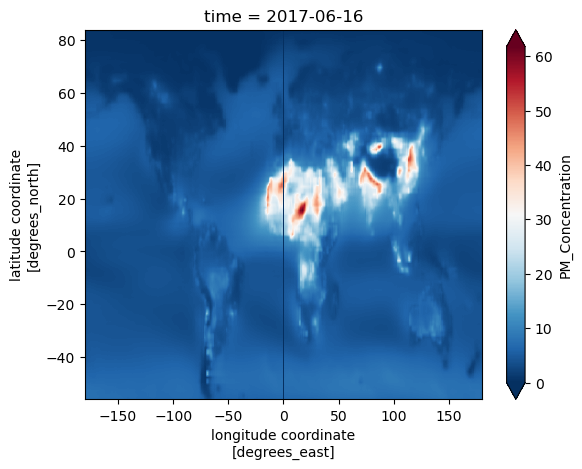

In [6]:
model_mean.plot(cmap='RdBu_r',cbar_kwargs={'label':'PM_Concentration'}, extend='both')

Text(0.5, 1.0, 'Multi-model mean annual mean PM2.5 for 2015-2019')

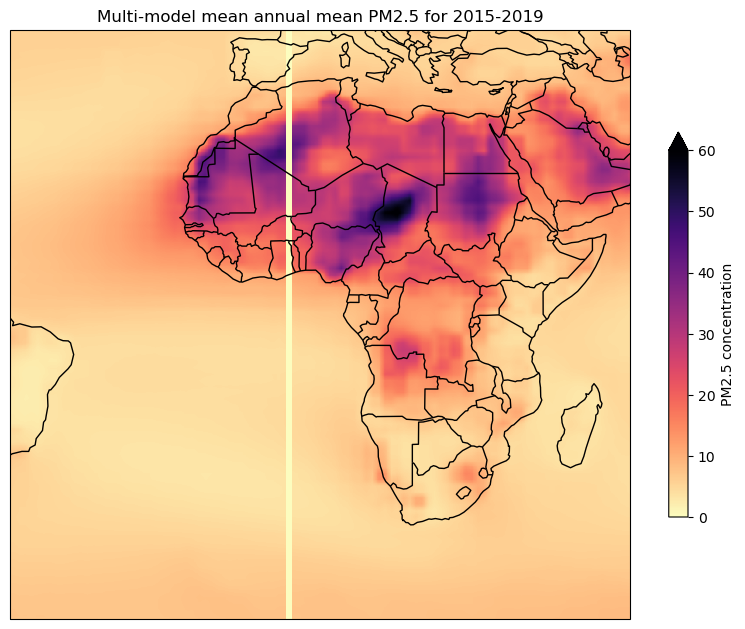

In [7]:
#%% to ensure colour mapping is the same for model and measurements,
# find appropriate limits for both

# take whichever is higher, model/obs 95th quantile
vmax = max(obs_mean['pm25_concentration'].quantile(.95).item(),
           model_mean.quantile(.95).item())

#%% plot figure
# latlon_proj = ccrs.Robinson()

latlon_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=[10,10])

# add an axis with an orthographic projection
ax = fig.add_subplot(projection=latlon_proj)
# add coastlines
ax.coastlines()
# add borders
ax.add_feature(cf.BORDERS)
# ax.add_feature(cf.RIVERS)
# ax.add_feature(cf.LAKES)
# ax.add_feature(cf.STATES)

# set map extent to match model grid
westlimit=-45.0; southlimit=-50.0; eastlimit=55.0; northlimit=45.0
ax.set_extent([westlimit, eastlimit, southlimit, northlimit],
              crs=latlon_proj) # must tell it coordinates are in latitude longitude


# add model data
model_mean.plot(ax=ax, vmin=0, vmax=vmax, cmap='magma_r',
                transform=latlon_proj, # must tell it coordinates are in latitude longitude
                cbar_kwargs={'shrink':.5,'label':'PM2.5 concentration'},
                zorder=0)

ax.set_title('Multi-model mean annual mean PM2.5 for 2015-2019')

Plot the WHO station data on top of the model data, as a global map:

Text(0.5, 1.0, 'Annual mean PM2.5 comparison')

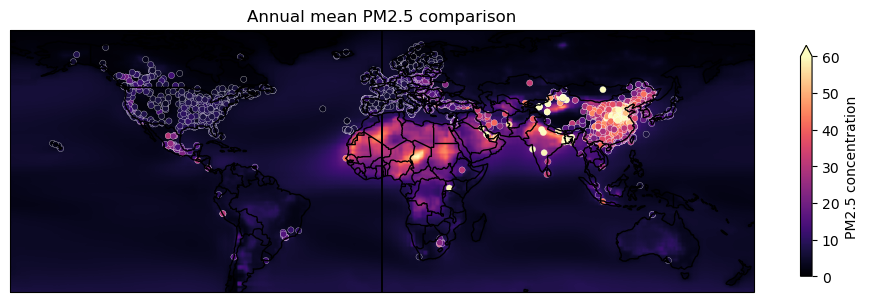

In [20]:
#%% plot figure
fig = plt.figure(figsize=[12,10])

# add an axis with an orthographic projection
ax = fig.add_subplot(projection=latlon_proj)
# add coastlines
ax.coastlines()
# add borders
ax.add_feature(cf.BORDERS)

# set map extent to match model grid
westlimit=-180.0; southlimit=-50.0; eastlimit=180.0; northlimit=77.0
ax.set_extent([westlimit, eastlimit, southlimit, northlimit],
              crs=latlon_proj) # must tell it coordinates are in latitude longitude


# add model data
model_mean.plot(ax=ax, vmin=0, vmax=vmax, cmap='magma',
                transform=latlon_proj, # must tell it coordinates are in latitude longitude
                cbar_kwargs={'shrink':.3, 'label':'PM2.5 concentration'},
                zorder=0)

# add measurement data
ax.scatter(x=coords.longitude, y=coords.latitude, transform=latlon_proj, # must tell it coordinates are in latitude longitude
            c=obs_mean.values, # make colour set by obs value,
            vmin=0, vmax=vmax, cmap='magma', # ensure colourbar is the same
           zorder=1, s=20, edgecolor='white', linewidth=.2)

ax.set_title('Annual mean PM2.5 comparison')

Plot the modelled and measured PM2.5 concentrations against each other to look at the spatial correlation and model bias:

In [ ]:

# Get model data at the location of the station
model_station = model_mean.sel(lat=coords.latitude.values,
                               lon=coords.longitude.values, method='nearest').values[0]
obs_station = np.squeeze(obs_mean.values)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot()#gs[0]
ax.set_facecolor('whitesmoke')
plt.ylabel('Modelled $PM_{2.5}$ (${\mu}g$ $m^{-3}$)', fontsize=14)
plt.xlabel('Measured $PM_{2.5}$ (${\mu}g$ $m^{-3}$)', fontsize=14)
vmax = 150
ax.set_xlim((0.0, vmax))
ax.set_ylim((0.0, vmax))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(obs_station, model_station,
            marker='o', lw=0, c='#7fbf7b', s=70, alpha=0.8)
x = np.arange(2 * vmax)
plt.plot(x, x, '', color='black', ls='dashed')
plt.plot(x, 0.5 * x, '', color='black', ls='dashed')
plt.plot(x, 2 * x, '', color='black', ls='dashed')

Calculate a statistical measure of model bias to assess the model performance:

In [ ]:
# Calculate the normalised mean bias factor
nmbf=((np.sum(model_station)-np.sum(obs_station))
      /np.absolute(np.sum(model_station)-np.sum(obs_station)))*(np.exp(np.absolute(np.log(np.sum(model_station)/np.sum(obs_station))))-1)

print('NMBF = ',round(nmbf,2))